# ARIMA Model Case Study(Johnson & Johnson Time Series Forecasting)

            Sales
date             
1960-01-01   0.71
1960-04-01   0.63
1960-07-02   0.85
1960-10-01   0.44
1961-01-01   0.61
Data shape: (84, 1)


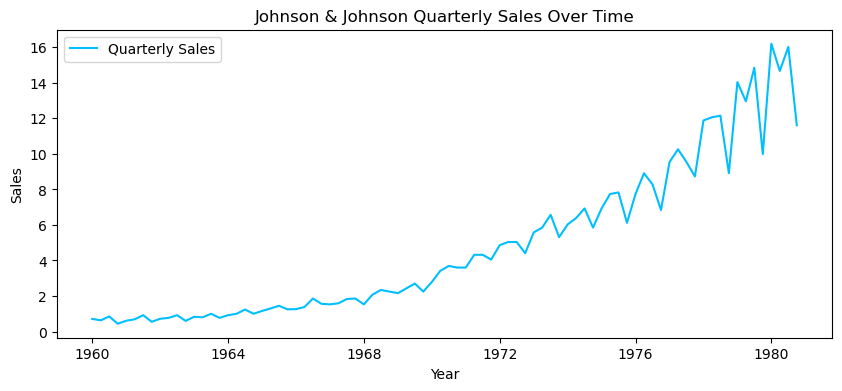

In [3]:
# Import Libraries and Load the Data
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# Load the dataset with date parsing
data = pd.read_csv('jj.csv', parse_dates=['date'])
data = data.set_index('date')
data = data.rename(columns={'data': 'Sales'}) 
print(data.head())
print("Data shape:", data.shape)

# Visualize the Original Time Series

plt.figure(figsize=(10, 4))
plt.plot(data.index, data['Sales'], color='deepskyblue', label='Quarterly Sales')
plt.title('Johnson & Johnson Quarterly Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()
plt.show()



# Stationarity (Augmented Dickey-Fuller Test)

In [4]:
# Check for Stationarity (Augmented Dickey-Fuller Test)

from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Sales'])
print(f"ADF Statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.3f}")

ADF Statistic: 2.742
p-value: 1.000


In [5]:
# Here, Data is non-stationary (p>0.05), 
# fail to reject the null hypothesis of a unit root.
# i.e,the time series is non-stationary 
# Make the Series Stationary (Log Transform and Differencing)

# Log transform the sales
log_sales = np.log(data['Sales'])

# Difference the log-transformed series
log_diff1 = log_sales.diff().dropna()

# ADF test on the differenced log series
result = adfuller(log_diff1)
print(f"ADF after 1st diff (log): {result[0]:.3f}")
print(f"p-value: {result[1]:.4f}")

ADF after 1st diff (log): -4.317
p-value: 0.0004


# ACF and PACF for the Stationary Series

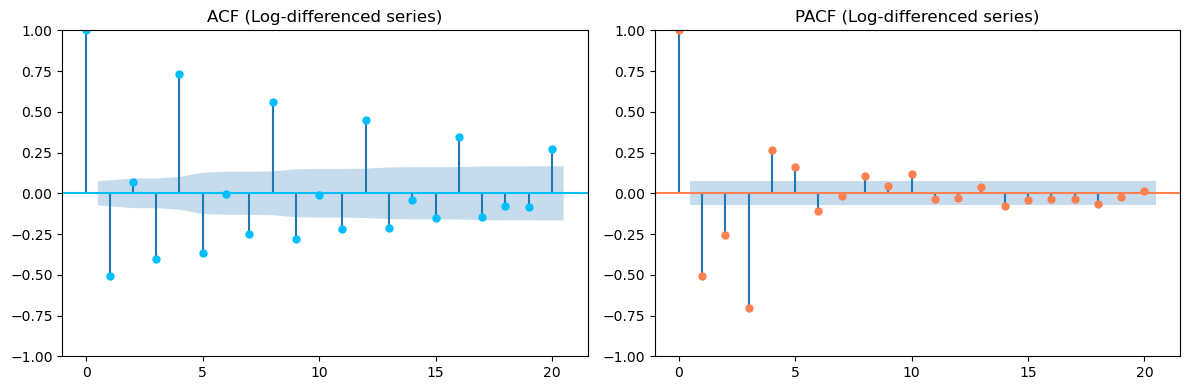

In [6]:
# Now stationary(p<0.05)

# Plot ACF and PACF for the Stationary Series

plt.figure(figsize=(12, 4))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(log_diff1, lags=20, ax=plt.gca(), title='ACF (Log-differenced series)', color='deepskyblue', alpha=0.5)

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(log_diff1, lags=20, ax=plt.gca(), title='PACF (Log-differenced series)', color='coral', alpha=0.5)

plt.tight_layout()
plt.show()


# ARMA Model Fit 

In [8]:
import statsmodels.api as sm

def find_optimal_arima_model(time_series, max_ar_terms, max_differences, max_ma_terms):
    """
    Function to determine the best ARIMA model based on AIC (Akaike Information Criterion).
    
    Parameters:
    time_series (pd.Series): Time series data.
    max_ar_terms (int): Maximum number of AR (Auto-Regressive) terms to consider.
    max_differences (int): Maximum number of differences allowed.
    max_ma_terms (int): Maximum number of MA (Moving Average) terms to consider.
    
    Returns:
    tuple: Best ARIMA model order (p, d, q) and the corresponding AIC value.
    """
    best_aic = float('inf')
    best_order = None
    best_model = None

    for p in range(max_ar_terms + 1):  # Including upper limit
        for d in range(max_differences + 1):
            for q in range(max_ma_terms + 1):
                try:
                    model = sm.tsa.arima.ARIMA(time_series, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                        best_model = results
                except Exception as e:
                    print(f"Failed to fit ARIMA({p},{d},{q}): {str(e)}")
                    continue

    print(f"Optimal ARIMA Model Order: {best_order} with AIC = {best_aic:.3f}")
    return best_order, best_aic, best_model

optimal_order, optimal_aic, optimal_model = find_optimal_arima_model(log_sales, 6, 2, 6)


Optimal ARIMA Model Order: (4, 1, 3) with AIC = -144.198


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   84
Model:                 ARIMA(4, 1, 3)   Log Likelihood                  80.099
Date:                Thu, 10 Apr 2025   AIC                           -144.198
Time:                        12:00:51   BIC                           -124.847
Sample:                             0   HQIC                          -136.423
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0005      0.060     -0.009      0.993      -0.118       0.116
ar.L2          0.0137      0.049      0.279      0.780      -0.083       0.110
ar.L3          0.0272      0.048      0.565      0.5

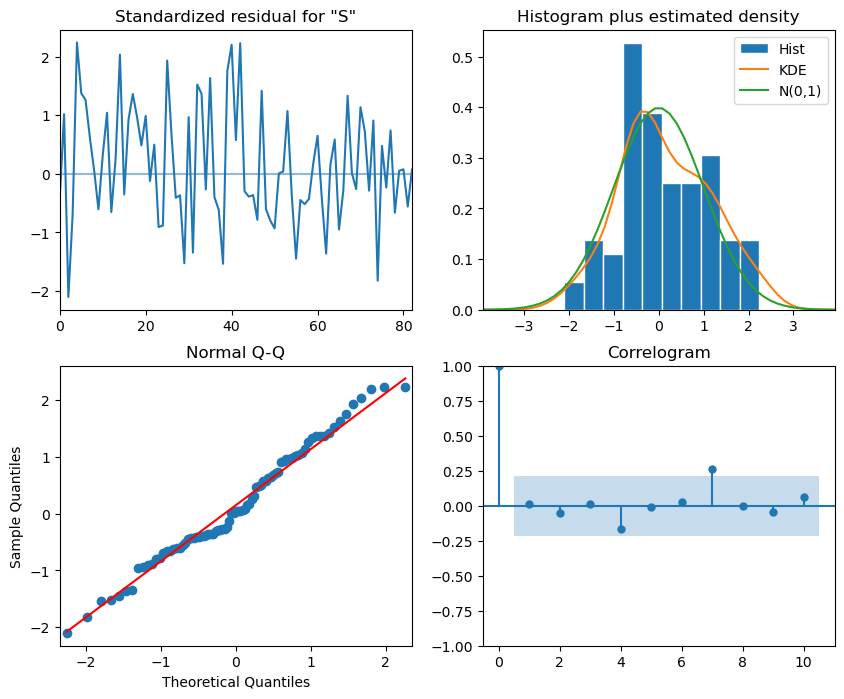

In [10]:
# Fit the chosen ARIMA model
model = sm.tsa.arima.ARIMA(log_sales, order=(4, 1, 3))
model_fit = model.fit()
print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In [11]:
# Compute In-Sample Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get in-sample predictions (log scale) and convert to original scale
predictions = model_fit.get_prediction(start=log_sales.index[0], dynamic=False)
predicted_log = predictions.predicted_mean
predicted_sales = np.exp(predicted_log)

# Align actual sales with predicted indices
actual_sales = data.loc[predicted_log.index, 'Sales']

# Calculate metrics
mae = mean_absolute_error(actual_sales, predicted_sales)
mse = mean_squared_error(actual_sales, predicted_sales)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_sales - predicted_sales) / actual_sales)) * 100

print("\nModel Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Model Evaluation Metrics:
MAE: 0.28
MSE: 0.16
RMSE: 0.40
MAPE: 8.21%


# Forecast the Next 24 Months 

In [12]:
# Forecast 8 steps ahead (8 quarters = 24 months)
n_steps = 8
forecast_result = model_fit.get_forecast(steps=n_steps)
# Predicted mean in log scale and its conf. interval
log_forecast = forecast_result.predicted_mean
log_conf_int = forecast_result.conf_int()

# Convert forecasts back to original scale
forecast = np.exp(log_forecast)
conf_int_lower = np.exp(log_conf_int['lower Sales'])
conf_int_upper = np.exp(log_conf_int['upper Sales'])

# Display the forecast values and confidence intervals
forecast.index = pd.date_range(start='1981-01-01', periods=n_steps, freq='Q')
print(forecast)
print(conf_int_lower)
print(conf_int_upper)


1981-03-31    18.040641
1981-06-30    16.652442
1981-09-30    18.003913
1981-12-31    13.452457
1982-03-31    20.327859
1982-06-30    18.816207
1982-09-30    20.201683
1982-12-31    15.522581
Freq: Q-DEC, Name: predicted_mean, dtype: float64
84    15.183629
85    13.882934
86    14.763898
87    11.005079
88    15.417940
89    14.100820
90    14.869924
91    11.357666
Name: lower Sales, dtype: float64
84    21.435241
85    19.974439
86    21.954965
87    16.444097
88    26.801366
89    25.108444
90    27.445196
91    21.214790
Name: upper Sales, dtype: float64


# Johnson & Johnson Sales Forecast for Next 8 Quarters(24 months)

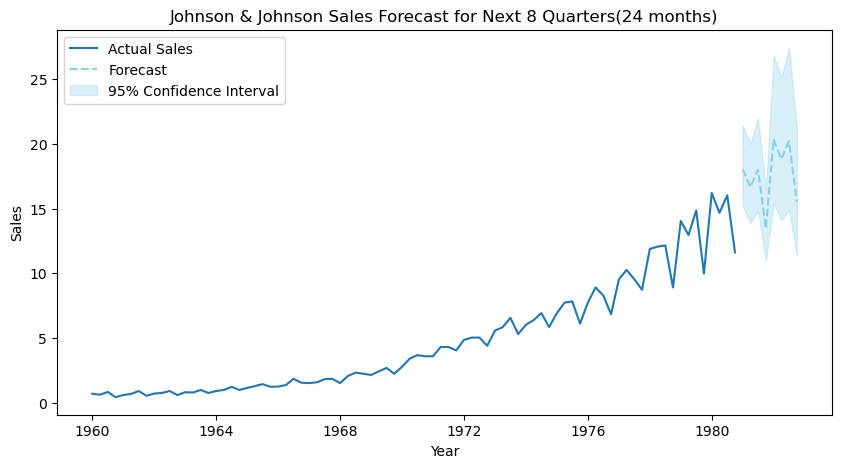

In [16]:
# Plot the Forecast vs Original Series

# Prepare index for forecast periods
forecast_index = pd.date_range(start='1980-10-01', periods=8, freq='Q')
# Plot the original series and forecast
plt.figure(figsize=(10,5))
plt.plot(data.index, data['Sales'], label='Actual Sales')
plt.plot(forecast_index, forecast.values, label='Forecast', color='skyblue', linestyle='--')
# Plot confidence interval as shaded area
plt.fill_between(forecast_index, conf_int_lower.values, conf_int_upper.values, 
                 color='skyblue', alpha=0.3, label='95% Confidence Interval')
plt.title('Johnson & Johnson Sales Forecast for Next 8 Quarters(24 months)')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.show()


# LSTM and GRU Model Case Study on Johnson & Johnson Sales Data Time Series Forecasting


Training LSTM model...
Training GRU model...

Model Performance Comparison:
Metric     LSTM            GRU            
MAE        1.62           1.28
MSE        4.48           2.25
RMSE       2.12           1.50
MAPE (%)   13.19           10.03


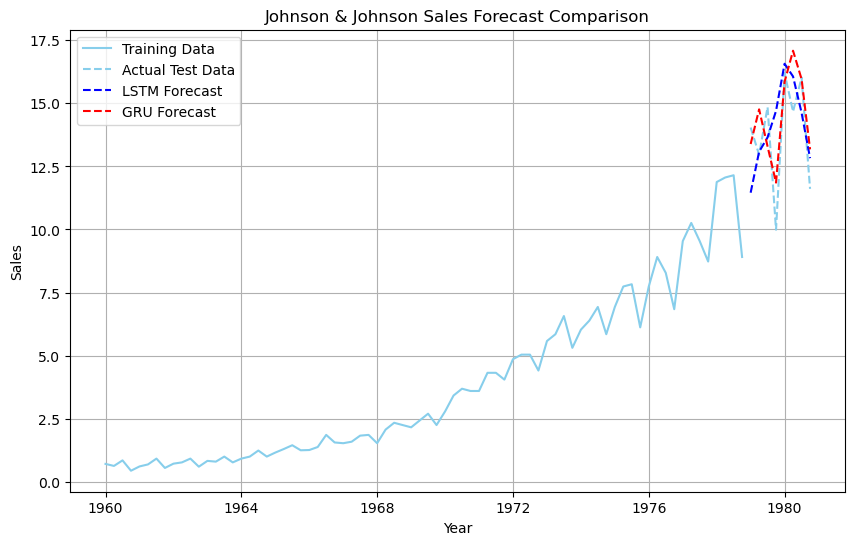

In [18]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import tensorflow as tf

def load_and_preprocess_data(filepath, test_size=8):
    """Load and preprocess time series data"""
    df = pd.read_csv(filepath, parse_dates=['date'])
    df.set_index('date', inplace=True)
    series = df['data']
    
    # Train-test split
    train = series.iloc[:-test_size]
    test = series.iloc[-test_size:]
    
    return train, test, series

def make_stationary_series(train_series):
    """Apply log transformation and differencing"""
    train_log = np.log(train_series.values)
    train_log_diff = np.diff(train_log, n=1)
    return train_log, train_log_diff

def create_sequences(data, window_size):
    """Create input-output sequences for time series modeling"""
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

def build_model(model_type='lstm', window_size=8, units=50, activation='tanh'):
    """Build LSTM/GRU model architecture"""
    model = Sequential()
    if model_type.lower() == 'lstm':
        model.add(LSTM(units, activation=activation, input_shape=(window_size, 1)))
    elif model_type.lower() == 'gru':
        model.add(GRU(units, activation=activation, input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def forecast_series(model, initial_window, initial_log, scaler, steps=8, window_size=8):
    """Generate recursive forecasts using trained model"""
    forecasts = []
    current_window = scaler.transform(initial_window.reshape(-1, 1)).flatten()
    current_log = initial_log
    
    for _ in range(steps):
        # Reshape input for model
        input_seq = current_window.reshape(1, window_size, 1)
        
        # Predict next difference
        pred_diff_scaled = model.predict(input_seq, verbose=0)[0, 0]
        pred_diff = scaler.inverse_transform([[pred_diff_scaled]])[0, 0]
        
        # Update log value and window
        current_log += pred_diff
        forecasts.append(np.exp(current_log))
        current_window = np.append(current_window[1:], pred_diff_scaled)
    
    return np.array(forecasts)

def evaluate_forecasts(actual, predictions):
    """Calculate evaluation metrics"""
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    
    return {
        'MAE': mean_absolute_error(actual, predictions),
        'MSE': mean_squared_error(actual, predictions),
        'RMSE': np.sqrt(mean_squared_error(actual, predictions)),
        'MAPE': np.mean(np.abs((actual - predictions) / actual)) * 100
    }

def plot_results(train_series, test_series, forecasts, model_names):
    """Visualize actual vs predicted values"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_series.index, train_series, label='Training Data', color='skyblue')
    plt.plot(test_series.index, test_series, label='Actual Test Data', color='skyblue', linestyle='--')
    
    colors = ['blue', 'red']
    for i, (name, values) in enumerate(zip(model_names, forecasts)):
        plt.plot(test_series.index, values, label=f'{name} Forecast', 
                color=colors[i], linestyle='--')
    
    plt.title('Johnson & Johnson Sales Forecast Comparison')
    plt.xlabel('Year')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Execution Flow
if __name__ == "__main__":
    # Configuration
    FILE_PATH = "jj.csv"
    WINDOW_SIZE = 8
    EPOCHS = 100
    TEST_SIZE = 8
    
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Load and preprocess data
    train, test, full_series = load_and_preprocess_data(FILE_PATH, TEST_SIZE)
    
    # Make series stationary
    train_log, train_log_diff = make_stationary_series(train)
    
    # Create sequences
    X_train, y_train = create_sequences(train_log_diff, WINDOW_SIZE)
    
    # Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    y_scaled = scaler.transform(y_train.reshape(-1, 1)).flatten()
    X_scaled = X_scaled.reshape((X_scaled.shape[0], WINDOW_SIZE, 1))
    
    # Build and train models
    lstm_model = build_model('lstm', WINDOW_SIZE)
    gru_model = build_model('gru', WINDOW_SIZE)
    
    print("Training LSTM model...")
    lstm_history = lstm_model.fit(X_scaled, y_scaled, epochs=EPOCHS, verbose=0)
    
    print("Training GRU model...")
    gru_history = gru_model.fit(X_scaled, y_scaled, epochs=EPOCHS, verbose=0)
    
    # Generate forecasts
    initial_window = train_log_diff[-WINDOW_SIZE:]
    initial_log = train_log[-1]
    
    lstm_forecast = forecast_series(lstm_model, initial_window, initial_log, scaler, TEST_SIZE, WINDOW_SIZE)
    gru_forecast = forecast_series(gru_model, initial_window, initial_log, scaler, TEST_SIZE, WINDOW_SIZE)
    
    # Evaluate performance
    lstm_metrics = evaluate_forecasts(test.values, lstm_forecast)
    gru_metrics = evaluate_forecasts(test.values, gru_forecast)
    
    print("\nModel Performance Comparison:")
    print(f"{'Metric':<10} {'LSTM':<15} {'GRU':<15}")
    print(f"{'MAE':<10} {lstm_metrics['MAE']:.2f}{'':<10} {gru_metrics['MAE']:.2f}")
    print(f"{'MSE':<10} {lstm_metrics['MSE']:.2f}{'':<10} {gru_metrics['MSE']:.2f}")
    print(f"{'RMSE':<10} {lstm_metrics['RMSE']:.2f}{'':<10} {gru_metrics['RMSE']:.2f}")
    print(f"{'MAPE (%)':<10} {lstm_metrics['MAPE']:.2f}{'':<10} {gru_metrics['MAPE']:.2f}")
    
    # Visualize results
    plot_results(train, test, [lstm_forecast, gru_forecast], ['LSTM', 'GRU'])

# ARIMA Model Case Study(Amazon Stock Close Price(Monthly) Time Series Forecasting)

                Close
Date                 
2018-02-20  73.417503
2018-02-21  74.146004
2018-02-22  74.266998
2018-02-23  75.000000
2018-02-26  76.097504
Number of monthly data points: 61


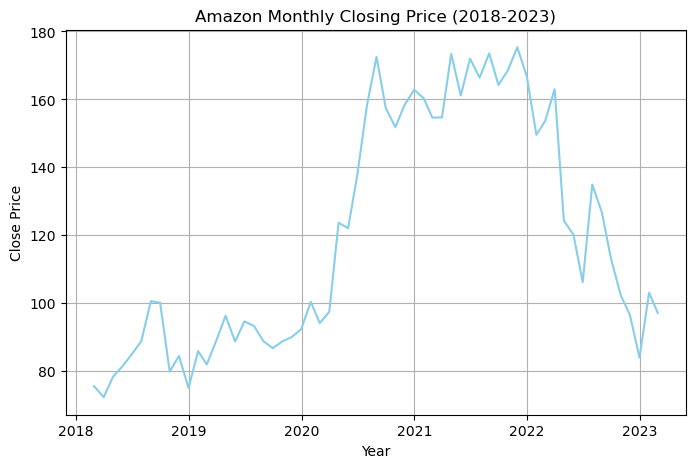

In [23]:
# Import Necessary Libraries
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data Preparation
# Load the dataset
df = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col='Date')
# The first few rows
print(df[['Close']].head())
# Resample to monthly frequency, taking the last closing price of each month
monthly_close = df['Close'].resample('M').last()
print("Number of monthly data points:", len(monthly_close))

# Visualize the Monthly Closing Price Time Series
#Plot Amazon Monthly Closing Price
plt.figure(figsize=(8,5))
plt.plot(monthly_close.index, monthly_close.values, color='skyblue')
plt.title('Amazon Monthly Closing Price (2018-2023)')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


# Test for Stationarity with Augmented Dickey-Fuller (ADF) Test

In [24]:
result = adfuller(monthly_close.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.5392301342169907
p-value: 0.5140232647833247


In [25]:
#p-value < 0.05
#The p-value ~ 0.51 is much greater than 0.05, 
#fail to reject the null hypothesis

#Make the Series Stationary – Log Transform and Differencing
# Log Transformation
log_close = np.log(monthly_close)
result_log = adfuller(log_close.dropna())
print("ADF Statistic (log):", result_log[0])
print("p-value (log):", result_log[1])


ADF Statistic (log): -1.6666161408109945
p-value (log): 0.4483896872175652


In [27]:
#After log transformation,still p > 0.05, 
#so the log series remains non-stationary.
#First Differencing (on Log-Transformed Data)
diff_log_close = log_close.diff().dropna()  # 1st difference of log series
result_diff_log = adfuller(diff_log_close)
print("ADF Statistic (log diff):", result_diff_log[0])
print("p-value (log diff):", result_diff_log[1])

ADF Statistic (log diff): -8.920696772064435
p-value (log diff): 1.0430561375247622e-14


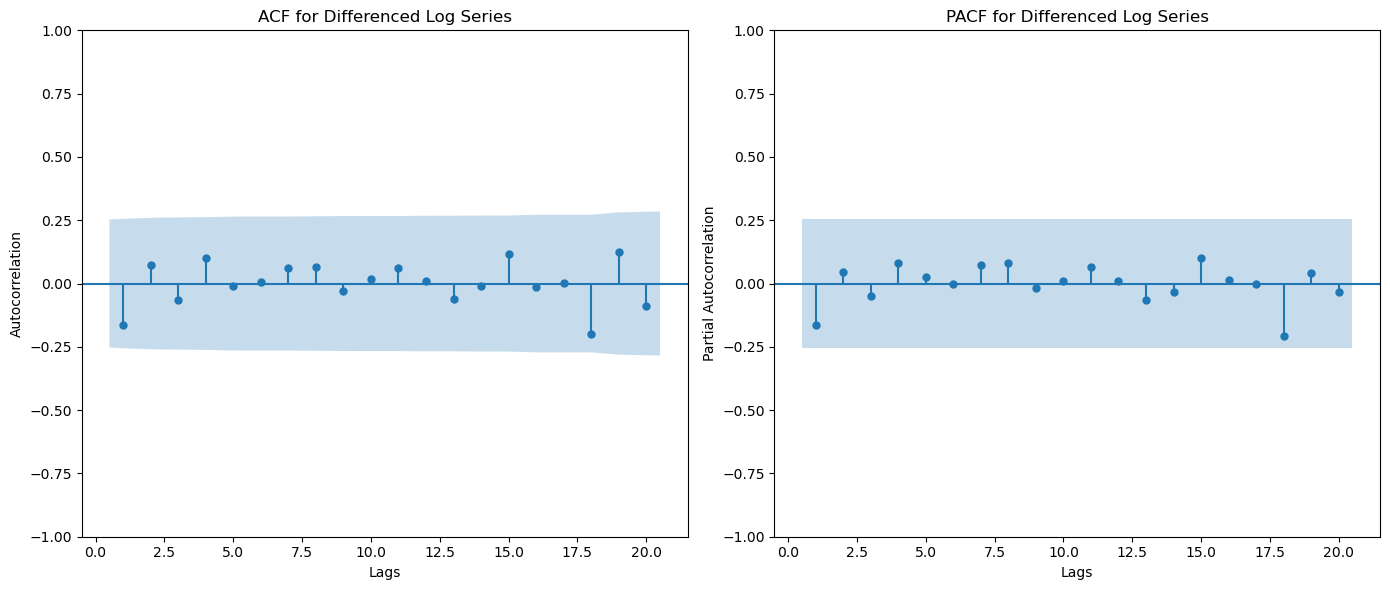

In [28]:
plt.figure(figsize=(14, 6))  # Adjusted figure size for better visibility

# Plotting ACF
plt.subplot(1, 2, 1)
plot_acf(diff_log_close, ax=plt.gca(), lags=20, zero=False, title='ACF for Differenced Log Series')
plt.xlabel('Lags')  # Adding x-axis label for clarity
plt.ylabel('Autocorrelation')  # Adding y-axis label for clarity

# Plotting PACF
plt.subplot(1, 2, 2)
plot_pacf(diff_log_close, ax=plt.gca(), lags=20, zero=False, title='PACF for Differenced Log Series')
plt.xlabel('Lags')  
plt.ylabel('Partial Autocorrelation')  
plt.tight_layout()
plt.show()


In [29]:
#Manual Grid Search for ARIMA(p,d,q) using AIC
import warnings
warnings.filterwarnings("ignore")  # ignore convergence warnings for some models
best_aic = np.inf
best_order = None
for p in range(0,10):
    for q in range(0,10):
        try:
            model = ARIMA(log_close, order=(p, 1, q))
            res = model.fit()
            print(f"ARIMA({p},1,{q}) AIC: {res.aic:.2f}")
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p,1,q)
        except Exception:
            continue
print(f"Best model by AIC: ARIMA{best_order} with AIC={best_aic:.2f}")


ARIMA(0,1,0) AIC: -107.97
ARIMA(0,1,1) AIC: -107.40
ARIMA(0,1,2) AIC: -105.61
ARIMA(0,1,3) AIC: -103.69
ARIMA(0,1,4) AIC: -102.42
ARIMA(0,1,5) AIC: -100.42
ARIMA(0,1,6) AIC: -98.44
ARIMA(0,1,7) AIC: -96.88
ARIMA(0,1,8) AIC: -95.09
ARIMA(0,1,9) AIC: -93.25
ARIMA(1,1,0) AIC: -107.56
ARIMA(1,1,1) AIC: -105.99
ARIMA(1,1,2) AIC: -104.02
ARIMA(1,1,3) AIC: -102.07
ARIMA(1,1,4) AIC: -100.42
ARIMA(1,1,5) AIC: -98.42
ARIMA(1,1,6) AIC: -97.01
ARIMA(1,1,7) AIC: -95.25
ARIMA(1,1,8) AIC: -93.38
ARIMA(1,1,9) AIC: -91.45
ARIMA(2,1,0) AIC: -105.73
ARIMA(2,1,1) AIC: -104.02
ARIMA(2,1,2) AIC: -102.08
ARIMA(2,1,3) AIC: -100.26
ARIMA(2,1,4) AIC: -98.83
ARIMA(2,1,5) AIC: -96.73
ARIMA(2,1,6) AIC: -97.36
ARIMA(2,1,7) AIC: -97.85
ARIMA(2,1,8) AIC: -91.28
ARIMA(2,1,9) AIC: -89.43
ARIMA(3,1,0) AIC: -103.89
ARIMA(3,1,1) AIC: -102.08
ARIMA(3,1,2) AIC: -100.20
ARIMA(3,1,3) AIC: -98.68
ARIMA(3,1,4) AIC: -96.93
ARIMA(3,1,5) AIC: -94.87
ARIMA(3,1,6) AIC: -97.63
ARIMA(3,1,7) AIC: -96.26
ARIMA(3,1,8) AIC: -89.41
ARIMA(3

In [30]:
# Chosen ARIMA(7,1,9) model fit on the log-transformed series for best accuracy plot
model = ARIMA(log_close, order=(7, 1, 9))
results = model.fit()

In [31]:
# Compute In-Sample Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get in-sample predictions (log scale)
predictions = results.get_prediction(start=log_close.index[0], dynamic=False)
predicted_log = predictions.predicted_mean

# Convert to original scale and align with actual prices
predicted_prices = np.exp(predicted_log)
actual_prices = monthly_close.loc[predicted_log.index]

# Calculate metrics
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print("\nModel Evaluation Metrics:")
print(f"MAE: ${mae:.2f}")
print(f"MSE: ${mse:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Model Evaluation Metrics:
MAE: $8.78
MSE: $200.45
RMSE: $14.16
MAPE: 8.14%


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   61
Model:                 ARIMA(7, 1, 9)   Log Likelihood                  59.567
Date:                Thu, 10 Apr 2025   AIC                            -85.134
Time:                        12:51:22   BIC                            -49.530
Sample:                    02-28-2018   HQIC                           -71.207
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1047     23.892      0.004      0.997     -46.724      46.933
ar.L2          0.6516     18.272      0.036      0.972     -35.160      36.463
ar.L3         -0.0769      0.835     -0.092      0.9

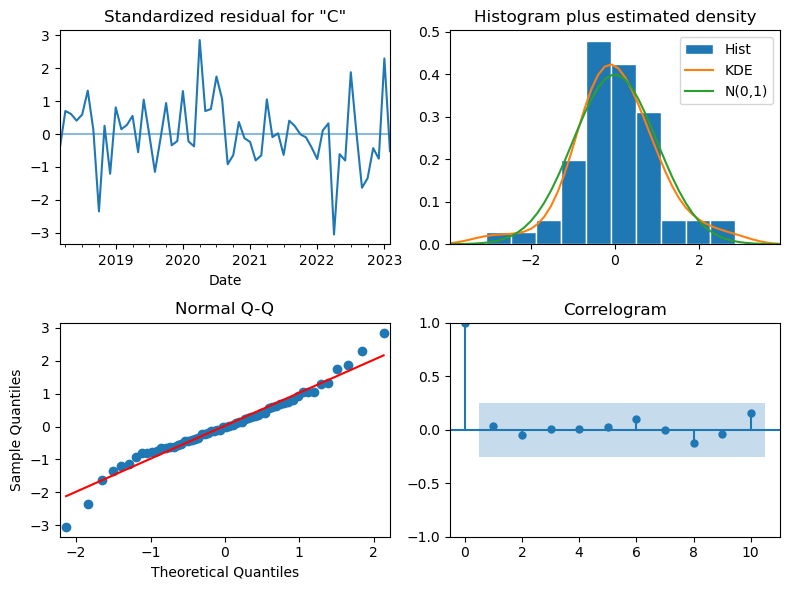

In [32]:
#Model Summary
print(results.summary())
#Diagnostic Plots
results.plot_diagnostics(figsize=(8,6))
plt.tight_layout()
plt.show()

# Forecast the Next 24 Months

2023-03-31    4.679200
2023-04-30    4.543133
2023-05-31    4.523113
2023-06-30    4.542894
2023-07-31    4.563650
Freq: M, Name: predicted_mean, dtype: float64


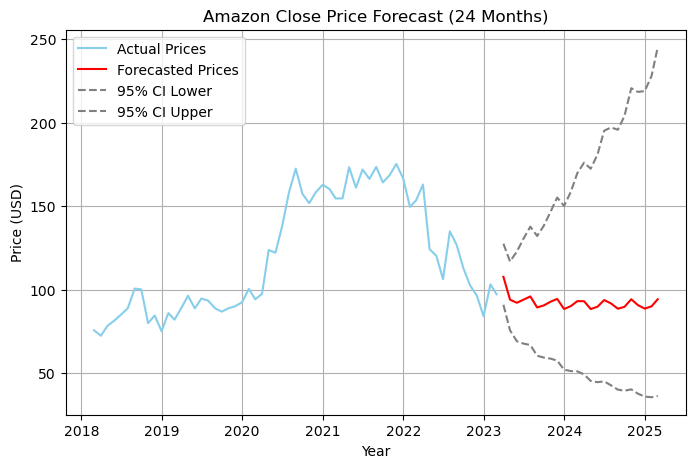

In [36]:
# Generate forecasts for the next 24 months (in log scale)
forecast_log = results.get_forecast(steps=24)
log_forecast_mean = forecast_log.predicted_mean  # predicted log prices
log_conf_int = forecast_log.conf_int()           # confidence intervals (log scale)
print(log_forecast_mean[:5])  # print first 5 forecasted log values for example

# Convert the forecast mean and confidence interval to original scale
forecast_mean = np.exp(log_forecast_mean)  # predicted price
conf_lower = np.exp(log_conf_int.iloc[:, 0])  # lower bound of 95% CI
conf_upper = np.exp(log_conf_int.iloc[:, 1])  # upper bound of 95% CI

#plot actual vs forecast with intervals
# Data setup
actual_prices = monthly_close.values
forecast_prices = forecast_mean.values
forecast_dates = forecast_mean.index
lower_confidence_interval = conf_lower
upper_confidence_interval = conf_upper

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(monthly_close.index, actual_prices, label='Actual Prices', color='skyblue')
plt.plot(forecast_dates, forecast_prices, label='Forecasted Prices', color='red')
plt.plot(forecast_dates, lower_confidence_interval, color='gray', linestyle='--', label='95% CI Lower')
plt.plot(forecast_dates, upper_confidence_interval, color='gray', linestyle='--', label='95% CI Upper')
plt.title('Amazon Close Price Forecast (24 Months)')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()



# LSTM and GRU Model Case Study on Amazon Stock Price Data Time Series Forecasting

LSTM Metrics: {'MAE': 173.85653661148854, 'MSE': 53034.60486465888, 'RMSE': 230.29243336388384, 'MAPE': 154.31241382789747}
GRU Metrics: {'MAE': 135.09528164047197, 'MSE': 31216.31518955292, 'RMSE': 176.6813945766586, 'MAPE': 121.39484959284788}


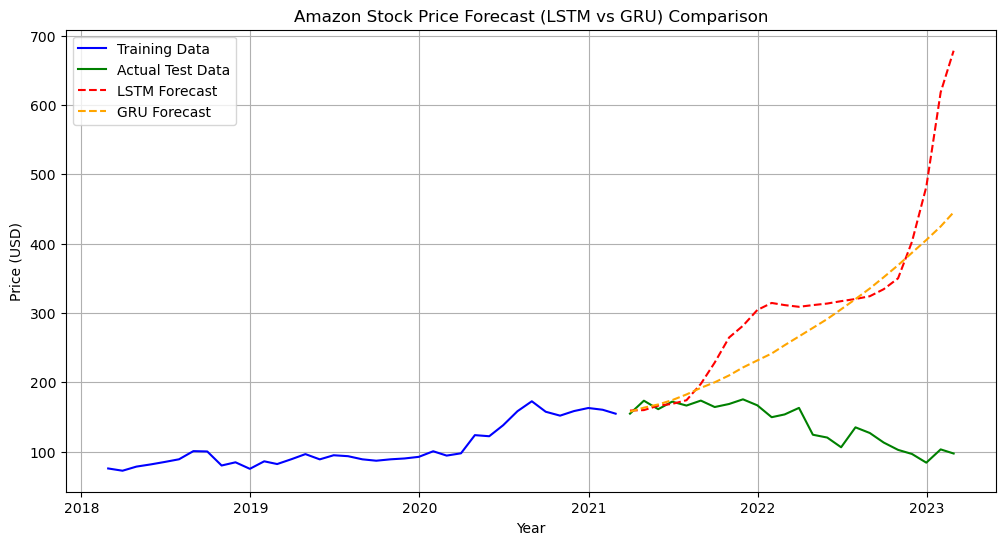

In [35]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import tensorflow as tf

def load_and_preprocess_data(filepath, test_size=24):
    """Load and preprocess time series data"""
    df = pd.read_csv(filepath, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    
    # Resample to monthly frequency
    monthly_series = df['Close'].resample('M').last()
    
    # Train-test split
    train_series = monthly_series.iloc[:-test_size]
    test_series = monthly_series.iloc[-test_size:]
    
    return train_series, test_series, monthly_series

def make_stationary_series(series):
    """Apply log transformation and differencing"""
    log_series = np.log(series)
    diff_series = log_series.diff().dropna()
    return log_series, diff_series

def create_sequences(data, window_size):
    """Create input-output sequences for time series modeling"""
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

def build_model(model_type='lstm', window_size=12, units=50, activation='relu'):
    """Build LSTM/GRU model architecture"""
    model = Sequential()
    if model_type.lower() == 'lstm':
        model.add(LSTM(units, activation=activation, input_shape=(window_size, 1)))
    elif model_type.lower() == 'gru':
        model.add(GRU(units, activation=activation, input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def forecast_future_prices(model, last_window, last_log_value, scaler, steps=24, window_size=12):
    """Generate recursive forecasts using trained model"""
    predictions = []
    current_window = last_window.copy()
    current_log = last_log_value
    
    for _ in range(steps):
        # Scale and reshape input
        scaled_window = scaler.transform(current_window.reshape(-1, 1))
        input_seq = scaled_window.reshape(1, window_size, 1)
        
        # Predict next difference
        pred_diff_scaled = model.predict(input_seq, verbose=0)
        pred_diff = scaler.inverse_transform(pred_diff_scaled)[0, 0]
        
        # Update log price and window
        current_log += pred_diff
        predictions.append(np.exp(current_log))
        current_window = np.append(current_window[1:], [pred_diff])
    
    return np.array(predictions)

def evaluate_forecasts(actual, predictions):
    """Calculate evaluation metrics"""
    metrics = {
        'MAE': mean_absolute_error(actual, predictions),
        'MSE': mean_squared_error(actual, predictions),
        'RMSE': np.sqrt(mean_squared_error(actual, predictions)),
        'MAPE': np.mean(np.abs((actual - predictions) / actual)) * 100
    }
    return metrics

def plot_results(train_series, test_series, forecasts, model_names):
    """Visualize actual vs predicted values"""
    plt.figure(figsize=(12, 6))
    plt.plot(train_series.index, train_series, label='Training Data', color='blue')
    plt.plot(test_series.index, test_series, label='Actual Test Data', color='green')
    
    colors = ['red', 'orange', 'purple']
    for i, (name, values) in enumerate(zip(model_names, forecasts)):
        plt.plot(test_series.index, values, label=f'{name} Forecast', 
                color=colors[i], linestyle='--')
    
    plt.title('Amazon Stock Price Forecast (LSTM vs GRU) Comparison')
    plt.xlabel('Year')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main Execution Flow
if __name__ == "__main__":
    # Configuration
    FILE_PATH = "AMZN.csv"
    WINDOW_SIZE = 12
    EPOCHS = 100
    TEST_SIZE = 24
    
    # Set random seeds
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Load and preprocess data
    train_series, test_series, full_series = load_and_preprocess_data(FILE_PATH, TEST_SIZE)
    
    # Make series stationary
    log_series, diff_series = make_stationary_series(full_series)
    train_diff = diff_series[:train_series.index.max()]
    
    # Create sequences
    X, y = create_sequences(train_diff.values, WINDOW_SIZE)
    
    # Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
    y_scaled = scaler.transform(y.reshape(-1, 1)).flatten()
    X_scaled = X_scaled.reshape((X_scaled.shape[0], WINDOW_SIZE, 1))
    
    # Build and train models
    lstm_model = build_model('lstm', WINDOW_SIZE)
    gru_model = build_model('gru', WINDOW_SIZE)
    
    lstm_history = lstm_model.fit(X_scaled, y_scaled, epochs=EPOCHS, verbose=0)
    gru_history = gru_model.fit(X_scaled, y_scaled, epochs=EPOCHS, verbose=0)
    
    # Generate forecasts
    last_window = train_diff[-WINDOW_SIZE:].values
    last_log = log_series[train_series.index.max()]
    
    lstm_forecast = forecast_future_prices(lstm_model, last_window, last_log, scaler, TEST_SIZE, WINDOW_SIZE)
    gru_forecast = forecast_future_prices(gru_model, last_window, last_log, scaler, TEST_SIZE, WINDOW_SIZE)
    
    # Evaluate performance
    lstm_metrics = evaluate_forecasts(test_series.values, lstm_forecast)
    gru_metrics = evaluate_forecasts(test_series.values, gru_forecast)
    
    print("LSTM Metrics:", lstm_metrics)
    print("GRU Metrics:", gru_metrics)
    
    # Visualize results
    plot_results(train_series, test_series, [lstm_forecast, gru_forecast], ['LSTM', 'GRU'])